In [95]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
from function_week_3 import *

## Feature based registration 

- The goal is to **identify** salient positions in an image (*unique key points*) and describe its **local** (*surrounding*) image context in the form of a descriptor vector. 
- Interest point features consits of two elements 
    - an interest point or a key point (a position in the image represented by an *(x,y)* coordinate)
    - descriptor (a vector encoding the apperance (i.e pixel intensities), in a local neighbourhood around the interest point

    

## 3.1 Exercise on feature based registration 

### 3.1.1 Rotation, translation and scale 

In [96]:
from function_week_3 import *

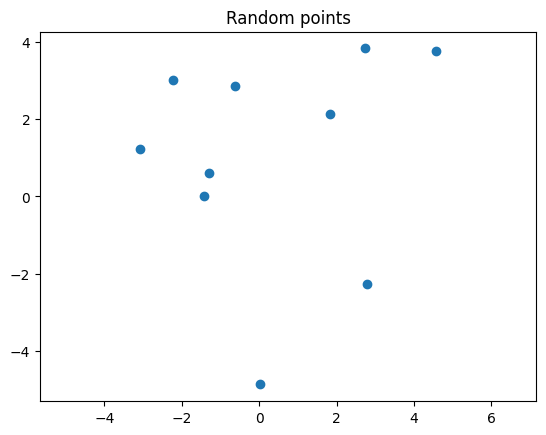

In [97]:
np.random.seed(1234)
n = 10
random_points = [(np.random.uniform(-5, 5), np.random.uniform(-5, 5)) for _ in range(n)]

# plot the coordinates 
plt.figure()
plt.plot([x for x, y in random_points], [y for x, y in random_points], 'o')
plt.axis('equal')
plt.title('Random points')
plt.show()


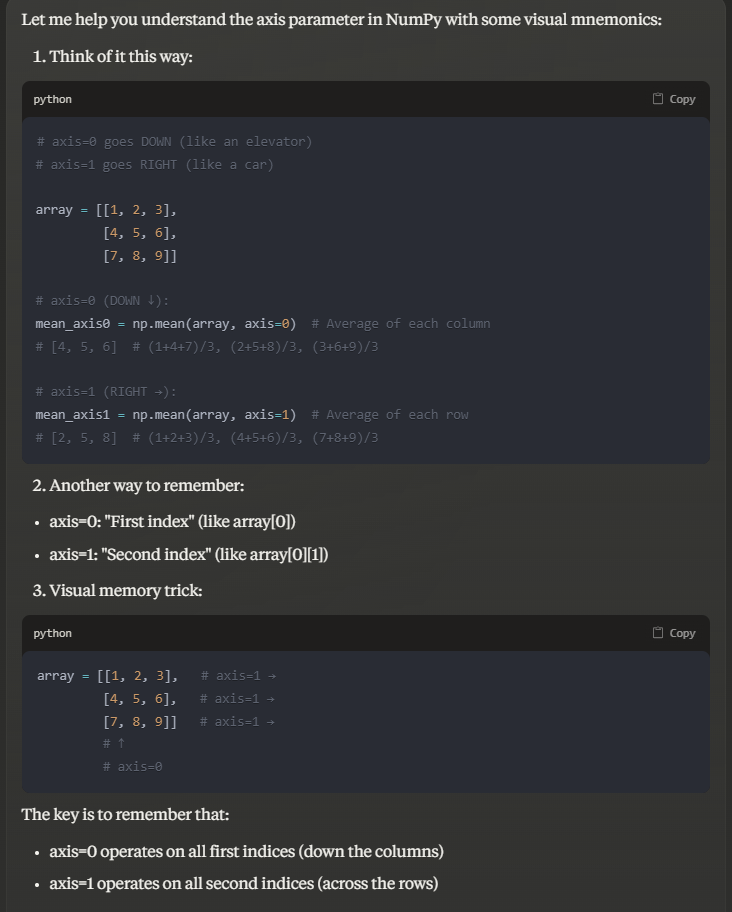

**************************************************
Parameters:
 s = 1.5
 theta = 0.7853981633974483
 t = [2 5]
 R = 
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
**************************************************


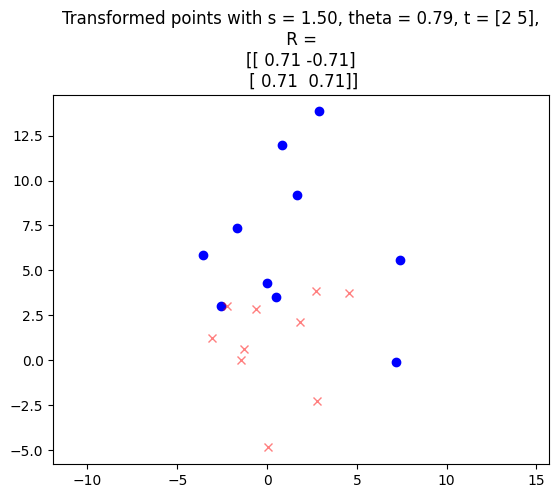

In [98]:
s = 1.5 # scale factor
theta = np.pi/4 # rotation angle
R = get_rotation_matrix(theta)
t = np.array((2, 5)) # translation

print("*" * 50 )
print(f"Parameters:\n s = {s}\n theta = {theta}\n t = {t}\n R = \n{R}")
print("*" * 50 )



# apply transformation to all points
transformed_points = [transform_pt(p, s, R, t) for p in random_points]

# plot the transformed points
plt.figure()
plt.plot([x for x, _ in transformed_points], [y for _, y in transformed_points], 'o', color='blue')
plt.plot([x for x, _ in random_points], [y for _, y in random_points], 'x', color='red', alpha=0.5)
plt.axis('equal')
plt.title(f"Transformed points with s = {s:.2f}, theta = {theta:.2f}, t = {t},\n R = \n{np.array_str(R, precision=2)}")
plt.show()

In [99]:
s_prime = compute_scale(random_points, transformed_points)

assert np.isclose(s, s_prime), f"Expected {s}, got {s_prime}"

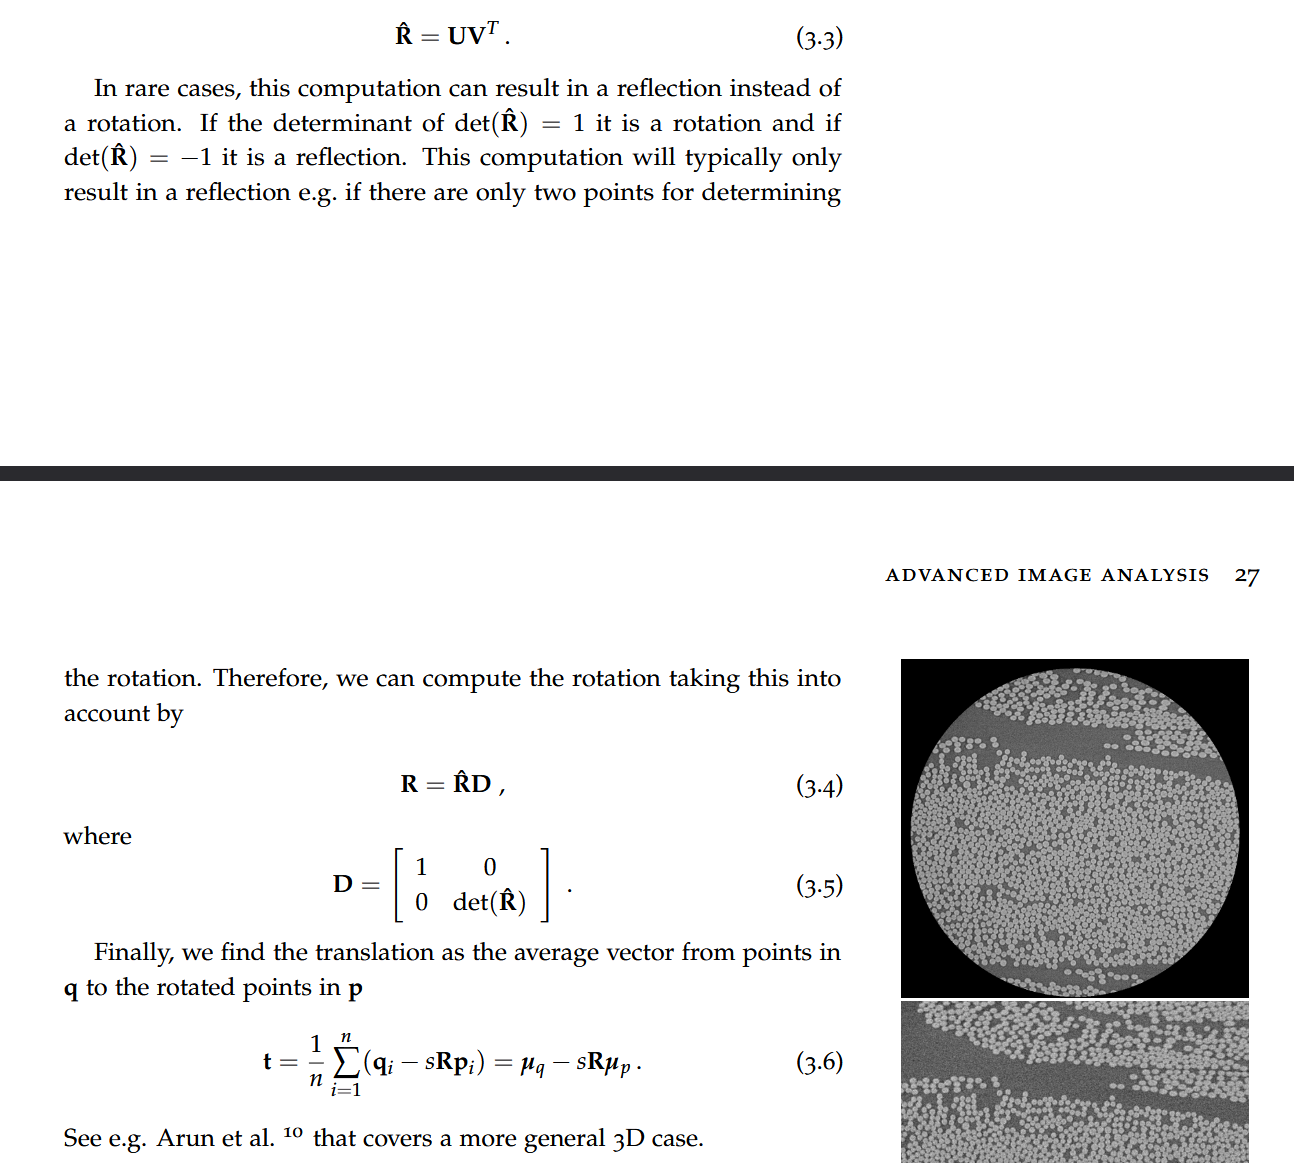

In [100]:
R_hat = covariance_matrix(random_points, transformed_points)

# Use a tolerance parameter in allclose
assert np.allclose(R_hat, R) 

# Or check if the difference is very small
diff = np.abs(R_hat - R).max()
print(f"Maximum difference between matrices: {diff}")

The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  0.9999999999999993
[[-0.32817401  0.94461729]
 [ 0.94461729  0.32817401]]
Maximum difference between matrices: 5.551115123125783e-16


In [101]:
def translation(p_set, q_set, R, s):
    # convert the p_set and q_set to np arrays 
    p_set, q_set = np.array(p_set), np.array(q_set)

    mu_p = np.mean(p_set, axis=0)
    mu_q = np.mean(q_set, axis=0)

    t = mu_q - s * np.dot(R, mu_p)
    return tuple(t.flatten())


In [102]:
t_hat = translation(random_points, transformed_points, R_hat, s)

print(t_hat)

assert np.allclose(t_hat, t)

(np.float64(2.0), np.float64(5.0))


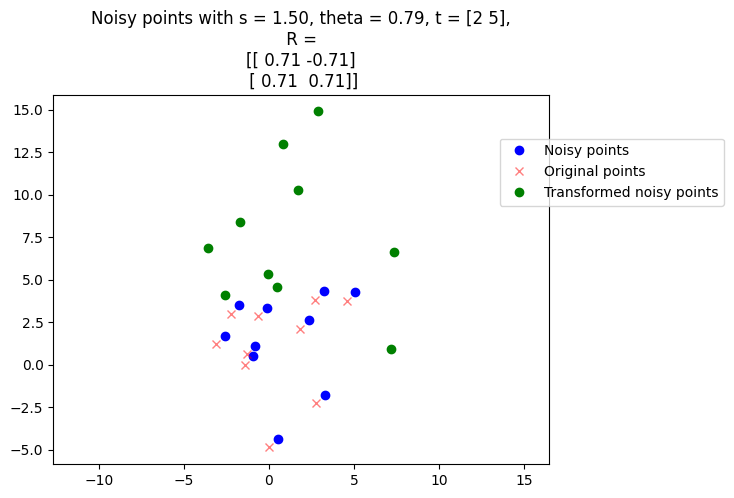

In [115]:
# add some noise to the q_set 

#seed
np.random.seed(1234)

noise = 0.5

noisy_points =  [(np.random.uniform(-5, 5) + noise, np.random.uniform(-5, 5) + noise)  for _ in range(n)]

transforme_noisy_points = [transform_pt(p, s, R, t) for p in noisy_points]

# plot the noisy points
plt.figure()
plt.plot([x for x, y in noisy_points], [y for x, y in noisy_points], 'o', color='blue')
plt.plot([x for x, y in random_points], [y for x, y in random_points], 'x', color='red', alpha=0.5)
plt.plot([x for x, y in transforme_noisy_points], [y for x, y in transforme_noisy_points], 'o', color='green')
plt.axis('equal')
plt.title(f"Noisy points with s = {s:.2f}, theta = {theta:.2f}, t = {t},\n R = \n{np.array_str(R, precision=2)}")
plt.legend(['Noisy points', 'Original points', 'Transformed noisy points'], loc=(0.9, 0.7))
plt.show()


In [116]:

s_prime = compute_scale(random_points, transforme_noisy_points)

# difference bewteen s and s_prime
diff_s_noisy = np.abs(s - s_prime)
print(f"Difference between s and s_prime: {diff_s_noisy}")

Difference between s and s_prime: 0.0


In [117]:
R_hat = covariance_matrix(random_points, transforme_noisy_points)

# difference between R and R_hat
diff_R_noisy = np.abs(R - R_hat).max()
print(f"Maximum difference between matrices: {diff_R_noisy}")

The mean of p is  (2,)
The shape of U is  (2, 2)
The shape of sigma is  (2,)
The shape of Vt is  (2, 2)
Sign of det is  1.0000000000000002
[[-0.32817401  0.94461729]
 [ 0.94461729  0.32817401]]
Maximum difference between matrices: 1.1102230246251565e-16


In [118]:

def translation(p_set, q_set, R, s):
    # Convert input sets to NumPy arrays for vectorized operations.
    # This ensures that calculations can be performed efficiently.
    p_set, q_set = np.array(p_set), np.array(q_set)

    # Compute the centroid (mean point) of p_set.
    # The centroid is the average of all points in p_set.
    mu_p = np.mean(p_set, axis=0)

    # Compute the centroid (mean point) of q_set.
    # The centroid is the average of all points in q_set.
    mu_q = np.mean(q_set, axis=0)

    # Calculate the translation vector t.
    # Here, we aim to find t such that when we apply scaling s and rotation R to mu_p,
    # then add the translation vector t, we obtain mu_q.
    # The equation used is: t = mu_q - s * (R * mu_p)
    t = mu_q - s * np.dot(R, mu_p)

    # Flatten the translation vector to ensure it's a 1D tuple with two elements,
    # corresponding to the x and y translation components.
    # Returning a tuple makes the output consistent with the rest of the code.
    return tuple(t.tolist())

In [119]:
t_hat = translation(random_points, transforme_noisy_points, R_hat, s)

print(t_hat)

print(t)

(2.0, 6.060660171779821)
[2 5]


In [120]:
diff_t_noisy = np.abs(np.array(t) - np.array(t_hat)).flatten().max()
print(f"Maximum difference between t and t_hat: {diff_t_noisy}")

Maximum difference between t and t_hat: 1.060660171779821


: 